## Initialization

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels_path = '/datasets/faces/labels.csv'
labels = pd.read_csv(labels_path)

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.shape

(7591, 2)

In [4]:
labels.duplicated().sum()

0

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Observations
- There are 7591 faces in the dataset.

- There are no missing values or duplicates.

- The mean age of a person is 31, and the ages range from 1 year to 100 years.

## EDA

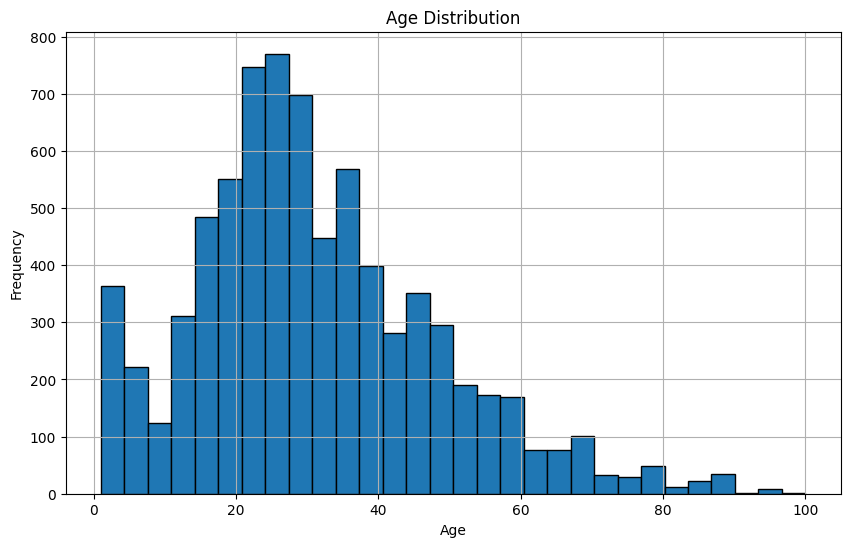

In [13]:
#Explore the age distribution in the dataset

plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

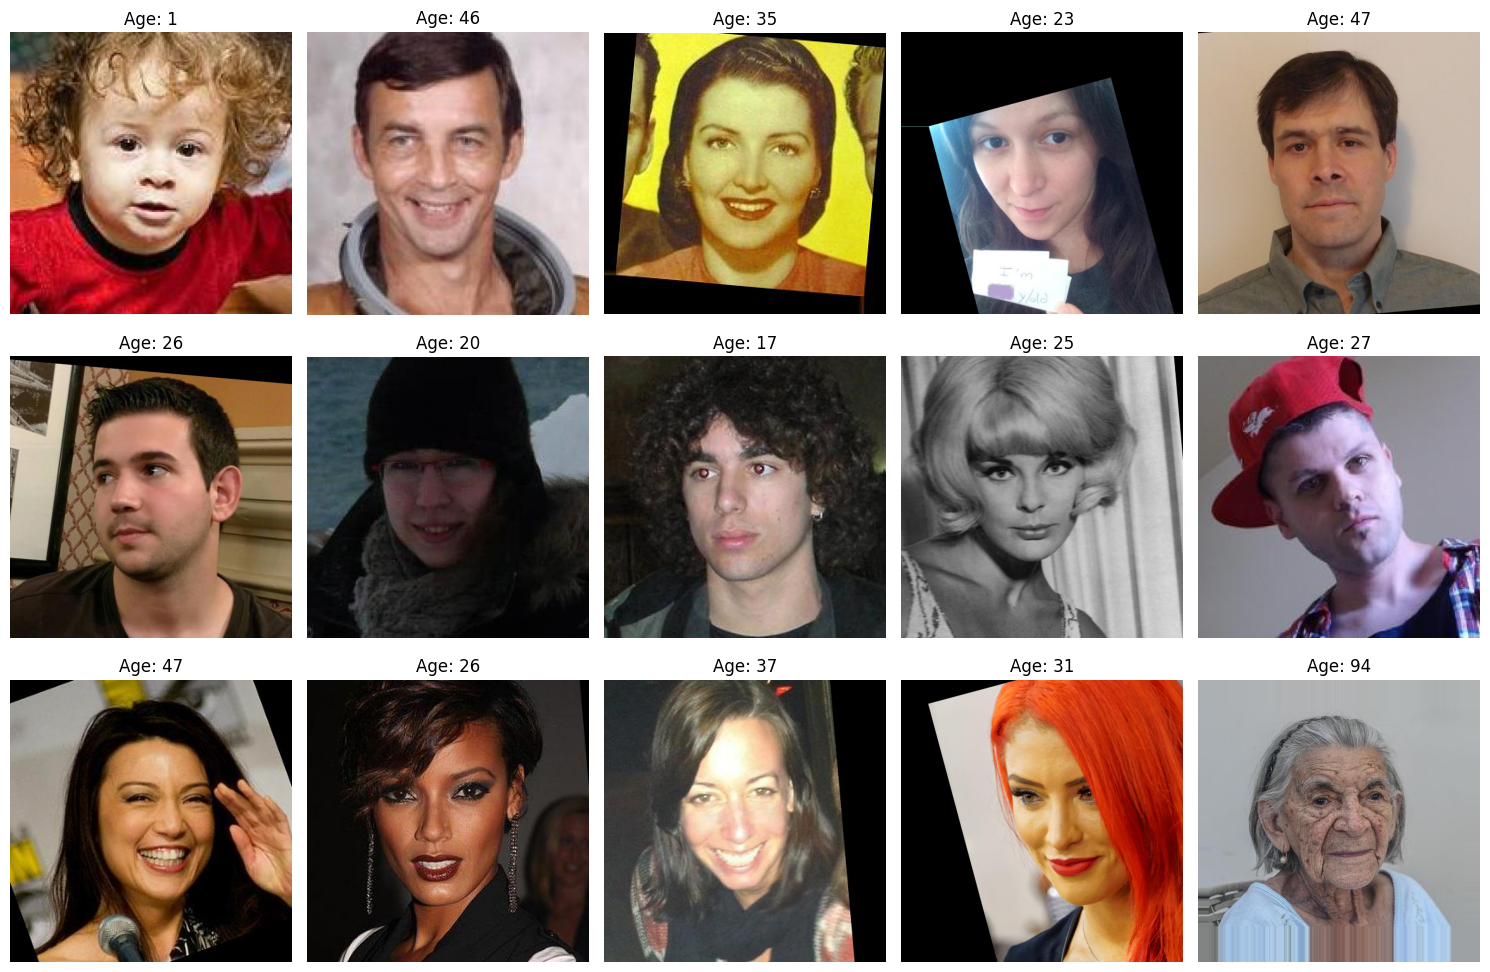

In [14]:
# Display 10-15 photos for different ages
images_dir = '/datasets/faces/final_files/'
sample_labels = labels.sample(15, random_state=42)  # Randomly select 15 images

plt.figure(figsize=(15, 10))
for i, row in enumerate(sample_labels.itertuples(), start=1):
    img_path = os.path.join(images_dir, row.file_name)
    img = Image.open(img_path)
    plt.subplot(3, 5, i)
    plt.imshow(img)
    plt.title(f"Age: {row.real_age}")
    plt.axis('off')
plt.tight_layout()
plt.show()

### Findings

- The histogram in the first image visualizes the age distribution of a dataset, showing a concentration of individuals in the 20-40 age range, with a decline in frequency for older ages.

- The data is distributed across 30 bins, with a notable peak around the 20s.

- The random selection of 15 images from the dataset, showcasing a diverse range of ages, from infants to elderly individuals (e.g., ages 1 to 94).

- The faces represent a mix of demographics, genders, and photographic styles, including casual and professional portraits.

- The selected images seem well-aligned with the corresponding age labels, and the random sampling ensures the dataset's integrity for further analysis.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [15]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [17]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

In [21]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [22]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [23]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

ound 6073 validated image filenames.
Found 1518 validated image filenames.
Epoch 1/20

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()

189/189 - 1171s - 6s/step - loss: 188.0712 - mae: 10.2916 - val_loss: 310.0190 - val_mae: 13.0986
Epoch 2/20

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)

189/189 - 8s - 43ms/step - loss: 127.6693 - mae: 8.2208 - val_loss: 410.0367 - val_mae: 15.7936
Epoch 3/20
189/189 - 84s - 442ms/step - loss: 103.6767 - mae: 7.7625 - val_loss: 374.8455 - val_mae: 14.4351
Epoch 4/20
189/189 - 0s - 2ms/step - loss: 129.0166 - mae: 9.2553 - val_loss: 554.9348 - val_mae: 15.9207
Epoch 5/20
189/189 - 82s - 436ms/step - loss: 76.7330 - mae: 6.6635 - val_loss: 371.1423 - val_mae: 14.2889
Epoch 6/20
189/189 - 1s - 6ms/step - loss: 41.5892 - mae: 5.4567 - val_loss: 733.4142 - val_mae: 20.7965
Epoch 7/20
189/189 - 70s - 368ms/step - loss: 45.8957 - mae: 5.1666 - val_loss: 153.4572 - val_mae: 9.0415
Epoch 8/20
189/189 - 0s - 2ms/step - loss: 67.2765 - mae: 6.2000 - val_loss: 129.3964 - val_mae: 9.3892
Epoch 9/20
189/189 - 70s - 372ms/step - loss: 31.5369 - mae: 4.3283 - val_loss: 102.2346 - val_mae: 7.9544
Epoch 10/20
189/189 - 0s - 2ms/step - loss: 21.8267 - mae: 4.1165 - val_loss: 124.9472 - val_mae: 8.4940
Epoch 11/20
189/189 - 70s - 370ms/step - loss: 25.6905 - mae: 3.8885 - val_loss: 77.7609 - val_mae: 6.6208
Epoch 12/20
189/189 - 1s - 4ms/step - loss: 44.9595 - mae: 5.7272 - val_loss: 59.4276 - val_mae: 6.2763
Epoch 13/20
189/189 - 69s - 366ms/step - loss: 22.2175 - mae: 3.6099 - val_loss: 74.0962 - val_mae: 6.6058
Epoch 14/20
189/189 - 1s - 6ms/step - loss: 20.0703 - mae: 3.4988 - val_loss: 33.2697 - val_mae: 4.6452
Epoch 15/20
189/189 - 70s - 368ms/step - loss: 16.8833 - mae: 3.1390 - val_loss: 95.4423 - val_mae: 7.8001
Epoch 16/20
189/189 - 0s - 2ms/step - loss: 14.7135 - mae: 2.9108 - val_loss: 96.7677 - val_mae: 8.1617
Epoch 17/20
189/189 - 70s - 370ms/step - loss: 15.4811 - mae: 2.9769 - val_loss: 83.2154 - val_mae: 7.0804
Epoch 18/20
189/189 - 0s - 2ms/step - loss: 11.4653 - mae: 2.7595 - val_loss: 57.1293 - val_mae: 5.9936
Epoch 19/20
189/189 - 69s - 366ms/step - loss: 14.8039 - mae: 2.9536 - val_loss: 80.4252 - val_mae: 6.9287
Epoch 20/20
189/189 - 1s - 4ms/step - loss: 6.8506 - mae: 2.0100 - val_loss: 74.9602 - val_mae: 5.8200


## Conclusions

The model trained on 6,073 images and validated on 1,518 images showed steady improvement over 20 epochs, achieving a training mean absolute error (MAE) of 2.01 years and a validation MAE of 5.82 years. Early epochs exhibited fluctuations in validation loss, suggesting potential overfitting or data complexity, but later epochs showed better stabilization. While the model demonstrates reasonable accuracy in predicting real ages, with an error margin of approximately 5–6 years, further improvements could be made through techniques like data augmentation, hyperparameter tuning, or early stopping to enhance generalization and reduce prediction error.

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training